In [1]:
import numpy as np
import torch.nn as nn
import torch, torchvision

import matplotlib.pyplot as plt

from Analog2SpikeDataset import SpikeDataset
from torch.utils.data import DataLoader

In [2]:
torch.manual_seed(0)

In [3]:
if torch.cuda.is_available():               # check GPU availability
    device = torch.device('cuda')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

device:  NVIDIA GeForce 930MX


## Simulation Parameters

In [4]:
batch_size = 32
nb_steps = 100
lr = 2e-4
epochs = 10
root = 'datasets'

## Training Data

In [5]:
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)

train_spks = SpikeDataset(train_dataset, num_steps=nb_steps)
test_spks = SpikeDataset(test_dataset, num_steps=nb_steps)

train_loader = DataLoader(train_spks, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_spks, batch_size=batch_size, shuffle=True, drop_last=True)

KeyboardInterrupt: 

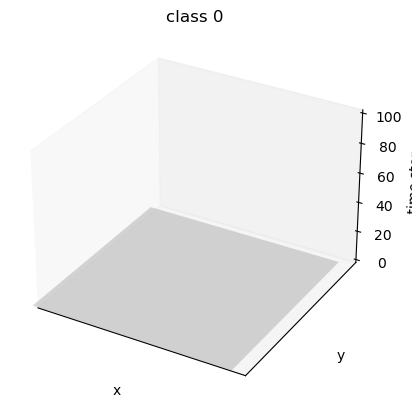

In [6]:
sample = train_spks[1]
x_ = sample[0]
y_ = sample[1]

x_ = np.array(x_.tolist())
y_ = np.array(y_.tolist())

train_spks.plot_sample(idx=1, save=True)

## Neuron Model

In [40]:
from SurrogateGradient import SpkSurrogateGradFunction

class LIFlayer(nn.Module):
    def __init__(self, tau_mem=10e-3, tau_syn=5e-3, threshold=1.0, t_step=1e-3, output=False):
        super().__init__()

        self.tau_mem = tau_mem
        self.tau_syn = tau_syn
        self.threshold = threshold
        self.t_step = t_step
        self.output = output

        self.beta = np.float64(np.exp(-self.t_step/self.tau_mem))
        self.alpha = np.float64(np.exp(-self.t_step/self.tau_syn))

        self.spike_fn = SpkSurrogateGradFunction.apply
        
        self.forwarded = False

    def reset_mem(self):
        self.forwarded = False
    
    def forward(self, x, k):

        if not hasattr(self, 'mem') or not self.forwarded:
            self.mem = torch.zeros_like(x, requires_grad=True)
            self.syn = torch.zeros_like(x, requires_grad=True)
            self.forwarded = True

        spk = self.spike_fn(self.mem, self.threshold, k)
        rst = spk.detach()

        self.syn = self.alpha*self.syn + x
        
        if self.output:
            self.mem = (self.beta*self.mem + self.syn)
        else:
            self.mem = (self.beta*self.mem + self.syn)*(1.0 - rst)

        return spk, self.mem

## Spiking FC Network

In [52]:
class SFCN(nn.Module):
    def __init__(self, nb_inputs: int, nb_hidden: int, nb_outputs: int, device):
        super().__init__()

        self.k = np.float64(100.0)

        self.l1LIF = LIFlayer()
        self.l2LIF = LIFlayer()
        self.l3LIF = LIFlayer(output=True)

        self.weight_scale = 7*(1.0-self.l1LIF.beta)

        self.w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=torch.float, requires_grad=True)
        torch.nn.init.normal_(self.w1, mean=0.0, std=self.weight_scale/np.sqrt(nb_inputs))

        self.w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=torch.float, requires_grad=True)
        torch.nn.init.normal_(self.w2, mean=0.0, std=self.weight_scale/np.sqrt(nb_hidden))

    def forward(self, x):
        batch_size = x.size(0)
        flat_inp = x.view(batch_size, -1)

        out1, mem1 = self.l1LIF(flat_inp, self.k)
        out2, mem2 = self.l2LIF(out1, self.k)
        out3, mem3 = self.l3LIF(out2, self.k)

        return out3, mem3
    
    def reset_states(self):
        self.l1LIF.reset_mem()
        self.l2LIF.reset_mem()
        self.l3LIF.reset_mem()
    
    @staticmethod
    def model_forward(model, data, nb_steps):
        spk_out_all = []
        mem_out_all = []
        model.reset_states()

        for step in range(nb_steps):
            spk_out, mem_out = model.forward(data[:, step:step+1, :, :])

            spk_out_all.append(spk_out)
            mem_out_all.append(mem_out)

        return torch.stack(spk_out_all, dim=1), torch.stack(mem_out_all, dim=1)

In [53]:
model = SFCN(28*28, 100, 10, device)

## Optimizer & Loss

In [54]:
params = [model.w1, model.w2]
optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

In [55]:
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

## Training Loop

In [58]:
losses = []
model.train()

for epoch in range(epochs):
    epochloss = 0
    counter = 0
    
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        out_spks, out_mems = SFCN.model_forward(model, data, nb_steps)
        m, _ = torch.max(out_mems, 1)
        log_p_y = log_softmax_fn(m)

        # initialize the loss & sum over time
        loss_val = loss_fn(log_p_y, targets.long())

        # gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        epochloss += loss_val.item()
        counter += 1
    
    epochloss = epochloss/counter
    losses.append(epochloss)

    print(f'epoch: {epoch}, loss: {epochloss}')

>  16.084497451782227
>  15.855835914611816
>  15.939240455627441
>  16.0877685546875
>  15.754672050476074
>  15.767939567565918
>  15.916739463806152
>  16.030406951904297
>  15.794391632080078
>  15.5509033203125
>  15.644532203674316
>  15.90166187286377
>  15.859195709228516
>  15.858988761901855
>  15.921900749206543
>  15.923966407775879
>  15.670565605163574
>  15.872771263122559
>  15.892617225646973
>  15.744593620300293
>  15.755549430847168
>  15.88656234741211
>  16.027599334716797
>  15.879928588867188
>  15.812296867370605
>  16.117910385131836
>  15.845526695251465
>  15.698928833007812


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Test Accuracy

In [ ]:
with torch.no_grad():
    total = 0
    correct = 0
    model.eval()

    test_loader = iter(test_loader)

    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        out_spks, out_mems = SFCN.model_forward(model, data, nb_steps)

        m, _ = torch.max(out_mems, 1)
        log_p_y = log_softmax_fn(m)

        _, predicted = torch.max(log_p_y, 1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'test accuracy: {correct/total}')